In [1]:
import DESTiler

#tiler=DESTiler.DESTiler("DES_DR1_TILE_INFO.csv")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
import os, sys
import pickle as pk
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.coordinates import SkyCoord
import yaml
from pixell import enmap,utils, reproject, enplot
from scipy import interpolate
import random
from astropy.nddata import block_reduce, block_replicate

from PIL import Image

from astLib import astWCS, astImages
from scipy import ndimage


%load_ext autoreload
%autoreload 2

%matplotlib inline



[nia-jupyter.scinet.local:21959] pml_ucx.c:285  Error: UCP worker does not support MPI_THREAD_MULTIPLE


In [10]:
tileDefinitions = {"mask": '/project/s/sievers/kaper/mlclusters/ml-clusters/DR5_cluster-search-area-mask_v1.0.fits',
                  "targetTileWidthDeg": 10.0, 
                  "targetTileHeightDeg": 5.0}
hdu = fits.open('/project/s/sievers/kaper/mlclusters/ml-clusters/DR5_cluster-search-area-mask_v1.0.fits')
mask = hdu[1].data
wcs_mask = astWCS.WCS(hdu[1].header,mode="pyfits")
tileOverlapDeg = 1

PermissionError: [Errno 13] Permission denied: '/project/s/sievers/kaper/mlclusters/ml-clusters/DR5_cluster-search-area-mask_v1.0.fits'

In [4]:
def autotiler(surveyMask, wcs, targetTileWidth, targetTileHeight):
    """Given a survey mask (where values > 0 indicate valid area, and 0 indicates area to be ignored), 
    figure out an optimal tiling strategy to accommodate tiles of the given dimensions. The survey mask need
    not be contiguous (e.g., AdvACT and SO maps, using the default pixelization, can be segmented into three
    or more different regions).
    
    Args:
        surveyMask (numpy.ndarray): Survey mask image (2d array). Values > 0 will be taken to define valid 
            area.
        wcs (astWCS.WCS): WCS associated with survey mask image.
        targetTileWidth (float): Desired tile width, in degrees (RA direction for CAR).
        targetTileHeight (float): Desired tile height, in degrees (dec direction for CAR).
    
    Returns:
        Dictionary list defining tiles in same format as config file.
    
    Note:
        While this routine will try to match the target file sizes, it may not match exactly. Also,
        :meth:`startUp.NemoConfig.getTileCoordsDict` will expand tiles by a user-specified amount such that
        they overlap.
    
    """
    
    # This deals with identifying boss vs. full AdvACT footprint maps 
    mapCentreRA, mapCentreDec=wcs.getCentreWCSCoords()    
    skyWidth, skyHeight=wcs.getFullSizeSkyDeg()
    if mapCentreRA < 0.1 and skyWidth < 0.1 or skyWidth > 359.9:
        handle180Wrap=True
    else:
        handle180Wrap=False
    
    segMap=surveyMask
    try:
        numObjects=ndimage.label(segMap, output = segMap)
    except:
        raise Exception("surveyMask given for autotiler is probably too complicated (breaks into > 256 regions) - check your mask and/or config file.")

    # More memory efficient than previous version
    fieldIDs=np.arange(1, numObjects+1, dtype = segMap.dtype)
    maskSections=ndimage.find_objects(segMap)
    tileList=[]
    for maskSection, f in zip(maskSections, fieldIDs):
        yMin=maskSection[0].start
        yMax=maskSection[0].stop-1
        if yMax-yMin < 1000:  # In case of stray individual pixels (e.g., combined with extended sources mask)
            continue
        xc=int((maskSection[1].start+(maskSection[1].stop-1))/2)

        # Some people want to run on full sky CAR ... so we have to avoid that blowing up at the poles
        decMin, decMax=np.nan, np.nan
        deltaY=0
        while np.isnan(decMin) and np.isnan(decMax):
            RAc, decMin=wcs.pix2wcs(xc, yMin+deltaY)
            RAc, decMax=wcs.pix2wcs(xc, yMax-deltaY)
            deltaY=deltaY+0.01

        numRows=int((decMax-decMin)/targetTileHeight)
        if numRows == 0:
            raise Exception("targetTileHeight is larger than the height of the map - edit your config file accordingly.")
        tileHeight=np.ceil(((decMax-decMin)/numRows)*100)/100

        for i in range(numRows):
            decBottom=decMin+i*tileHeight
            decTop=decMin+(i+1)*tileHeight
            xc, yBottom=wcs.wcs2pix(RAc, decBottom)
            xc, yTop=wcs.wcs2pix(RAc, decTop)
            yBottom=int(yBottom)
            yTop=int(yTop)
            yc=int((yTop+yBottom)/2)

            strip=segMap[yBottom:yTop]
            ys, xs=np.where(strip == f)
            xMin=xs.min()
            xMax=xs.max()
            del ys, xs, strip
            stripWidthDeg=(xMax-xMin)*wcs.getXPixelSizeDeg()
            RAMax, decc=wcs.pix2wcs(xMin, yc)
            RAMin, decc=wcs.pix2wcs(xMax, yc)
            numCols=int(stripWidthDeg/targetTileWidth)
            tileWidth=np.ceil((stripWidthDeg/numCols)*100)/100
            #assert(tileWidth < targetTileWidth*1.1)

            stretchFactor=1/np.cos(np.radians(decTop))
            numCols=int(stripWidthDeg/(targetTileWidth*stretchFactor))
            for j in range(numCols):
                tileWidth=np.ceil((stripWidthDeg/numCols)*100)/100
                RALeft=RAMax-j*tileWidth
                RARight=RAMax-(j+1)*tileWidth
                if RALeft < 0:
                    RALeft=RALeft+360
                if RARight < 0:
                    RARight=RARight+360
                # HACK: Edge-of-map handling
                if handle180Wrap == True:
                    if RARight < 180.01 and RALeft < 180+tileWidth and RALeft > 180.01:
                        RARight=180.01
                # NOTE: floats here to make tileDefinitions.yml readable
                tileList.append({'tileName': '%d_%d_%d' % (f, i, j),
                                 'RADecSection': [float(RARight), float(RALeft), float(decBottom), float(decTop)]})

    return tileList

In [5]:
tilelist = autotiler(mask,wcs_mask,tileDefinitions["targetTileWidthDeg"],tileDefinitions["targetTileHeightDeg"])

In [6]:
def getTileCoordsDict(tileList,wcs_mask,tileOverlapDeg):
    """Construct a dictionary that describes how a large map is broken up into smaller tiles
    (see :ref:`Tiling` for information on the relevant configuration file parameters).
    Returns:
        A dictionary indexed by tile name, where each entry is a dictionary containing information
        on pixel coordinates of each tile within the larger map, and the WCS of each tile.
    """
    # Spin through a map, figuring out the actual coords to clip based on the tile definitions
    clipCoordsDict={}

    # We can take any map, because we earlier verified they have consistent WCS and size
    wcs=wcs_mask
    # Tiled - this takes about 4 sec
    tileNames=[]
    coordsList=[]
    for tileDict in tileList:
            ra0, ra1, dec0, dec1=tileDict['RADecSection']
            x0, y0=wcs.wcs2pix(ra0, dec0)
            x1, y1=wcs.wcs2pix(ra1, dec1)
            xMin=min([x0, x1])
            xMax=max([x0, x1])
            yMin=min([y0, y1])
            yMax=max([y0, y1])
            coordsList.append([xMin, xMax, yMin, yMax])
            tileNames.append(tileDict['tileName'])
            
    # Define clip regions in terms of pixels, adding overlap region
    tileOverlapDeg=tileOverlapDeg
    mapData=np.ones([wcs.header['NAXIS2'], wcs.header['NAXIS1']], dtype = np.uint8)
    for c, name, tileDict in zip(coordsList, tileNames, tileList):
        y0=c[2]
        y1=c[3]
        x0=c[0]
        x1=c[1]
        ra0, dec0=wcs.pix2wcs(x0, y0)
        ra1, dec1=wcs.pix2wcs(x1, y1)
        # Be careful with signs here... and we're assuming approx pixel size is ok
        if x0-tileOverlapDeg/wcs.getPixelSizeDeg() > 0:
            ra0=ra0+tileOverlapDeg
        if x1+tileOverlapDeg/wcs.getPixelSizeDeg() < mapData.shape[1]:
            ra1=ra1-tileOverlapDeg
        if y0-tileOverlapDeg/wcs.getPixelSizeDeg() > 0:
            dec0=dec0-tileOverlapDeg
        if y1+tileOverlapDeg/wcs.getPixelSizeDeg() < mapData.shape[0]:
            dec1=dec1+tileOverlapDeg
        if ra1 > ra0:
            ra1=-(360-ra1)
        clip=astImages.clipUsingRADecCoords(mapData, wcs, ra1, ra0, dec0, dec1)

        # This bit is necessary to avoid Q -> 0.2 ish problem with Fourier filter
        # (which happens if image dimensions are both odd)
        # I _think_ this is related to the interpolation done in signals.fitQ
        if (clip['data'].shape[0] % 2 != 0 and clip['data'].shape[1] % 2 != 0) == True:
            newArr=np.zeros([clip['data'].shape[0]+1, clip['data'].shape[1]])
            newArr[:clip['data'].shape[0], :]=clip['data']
            newWCS=clip['wcs'].copy()
            newWCS.header['NAXIS1']=newWCS.header['NAXIS1']+1
            newWCS.updateFromHeader()
            testClip=astImages.clipUsingRADecCoords(newArr, newWCS, ra1, ra0, dec0, dec1)
            # Check if we see the same sky, if not and we trip this, we need to think about this more
            assert((testClip['data']-clip['data']).sum() == 0)
            clip['data']=newArr
            clip['wcs']=newWCS

        # Storing clip coords etc. so can stitch together later
        # areaMaskSection here is used to define the region that would be kept (takes out overlap)
        ra0, dec0=wcs.pix2wcs(x0, y0)
        ra1, dec1=wcs.pix2wcs(x1, y1)
        clip_x0, clip_y0=clip['wcs'].wcs2pix(ra0, dec0)
        clip_x1, clip_y1=clip['wcs'].wcs2pix(ra1, dec1)
        clip_x0=int(round(clip_x0))
        clip_x1=int(round(clip_x1))
        clip_y0=int(round(clip_y0))
        clip_y1=int(round(clip_y1))
        if name not in clipCoordsDict:
            clipCoordsDict[name]={'clippedSection': clip['clippedSection'], 'header': clip['wcs'].header,
                                  'areaMaskInClipSection': [clip_x0, clip_x1, clip_y0, clip_y1]}
    return clipCoordsDict

In [7]:
clipCoordsDict=getTileCoordsDict(tilelist,wcs_mask,tileOverlapDeg)

In [3]:
def make_jpg(path, box):
    '''
    Function which makes a np array which can be interpreted as a jpg
    
    Input: 
        path: str, path to where the maps we're making these jpgs from lives
        box: array([[ra_min, dec_min],[ra_max, dec_max]]) the box defining the edges of the jpg. Can be in either
             degrees or radians, but if in degrees must have attached astropy units i.e. u.deg
    Output:
        to_return: array([px, py, 3]) an array of stamps in the three frequencies, all at location box. 
        
    '''
    
    #Just lists the frequencies of the ACT maps. Note the ACT convention of 090 for 90GHz
    freqs = ['090', '150', '220']
    
    to_return = []
    
    for i, freq in enumerate(freqs):
        #For each frequeny, stamp out the box we're interested in. enmap.read_map reads in the map, reading only from inside
        #box, and returns a pixell map. [0] just selects only the data
        cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[i]), box=box)[0]
        to_return.append(normalize_map(cur_map))
    to_return = np.stack(to_return, axis=0)
    
    #Just some dimension rearanging 
    to_return = np.ascontiguousarray(to_return.transpose(1,2,0))
    return to_return

In [4]:
def normalize_map(imap):
    '''
    Normalizes a map in some way. Right now computes the average of the map and the STD, and then
    subtracts off the mean and divides by the std, returning a map with 0 mean and 1 std. We want to consider other
    methods for normalizing. Each frequency is normalized independantly (may want to reconsider this)
    
    Input:
        imap: array, the input map as an np array
    Ouptut:
        temp_map: array(imap.shap), the normalized input map
    
    '''
    temp_map = np.zeros(imap.shape)
    for j in range(imap.shape[-1]):
        #For each frequency, normalize the map
        temp = (imap[...,j]-np.mean(imap[...,j]))/np.std(imap[...,j])
        temp_map[...,j] = temp

    return temp_map

'''
def freq_cutout(ra, dec, freq_map, scale=399, width = 3.5*utils.arcmin):

    #A function for upscaling act maps, can ignore
    stamp = freq_stamp(ra, dec, freq_map, width = width)
    
    highres = block_replicate(stamp, scale)
    if stamp is None: return None
    mymin,mymax = 0,stamp.shape[1]-1
    X = np.linspace(mymin,mymax,stamp.shape[1])
    Y = np.linspace(mymin,mymax,stamp.shape[1])

    x,y = np.meshgrid(X,Y)

    f = interpolate.interp2d(x,y,stamp[0],kind='linear')

    Xnew, Ynew = np.linspace(0, stamp.shape[1], scale), np.linspace(0, stamp.shape[1], scale)

    #print(Xnew)

    highres = f(Xnew, Ynew)
    return highres

def freq_stamp(ra, dec, freq_map, width = 3.5*utils.arcmin):
    ra, dec = ra*u.deg, dec*u.deg
    stamp = reproject.thumbnails(freq_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width)
    
    return stamp
'''

In [5]:

'''
def cutout(ras,decs, freq_map_090, freq_map_150, freq_map_220, scale = 10):

    #Makes combined ACT+DES images, can ignore

    names = os.listdir('/project/r/rbond/jorlo/datasets/DESTileImages/')
    to_return = []
    for i in range(len(ras)):
        print(i, end = '\r')
        temp = np.zeros((380,380,8))
        ra, dec= ras[i], decs[i]

        tileName=tiler.getTileName(ra, dec)
        if tileName == None: continue
        for name in names:
            if tileName in name:
                fileName = name[:21]
                break
        bands = ['g', 'r', 'i', 'z', 'Y']
        for j, band in enumerate(bands):
            print('J: ', j)
            hi_data = fits.open('/project/r/rbond/jorlo/datasets/DESTileImages/{}_{}.fits.fz'.format(fileName,band))
            header = hi_data[1].header
            w = wcs.WCS(header)
            hdata = hi_data[1].data
            c = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            px, py = wcs.utils.skycoord_to_pixel(c, w)
            size = u.Quantity([scale, scale], u.arcmin)
            print(size)
            cutout = Cutout2D(hdata, (px,py), size,  wcs = w).data
            print(cutout.shape)
            if cutout.shape != (2281, 2281): continue
            temp[...,j] = block_reduce(cutout, 6, func = np.mean)
            

        freqs = ['090', '150', '220']
        
        for i, freq in enumerate(freqs):
            if freqs[i] == '090': freq_cut = freq_cutout(ra, dec, freq_map_090, scale = 380, width = scale/2*utils.arcmin)
            elif freqs[i] == '150': freq_cut = freq_cutout(ra, dec, freq_map_150, scale = 380, width = scale/2*utils.arcmin)
            elif freqs[i] == '220': freq_cut = freq_cutout(ra, dec, freq_map_220, scale = 380, width = scale/2*utils.arcmin)
            if freq_cut is None: continue
            temp[...,5+i] = freq_cut
        temp = normalize_map(temp)
        """
        if np.all(to_return) == 1:
            to_return = temp
        elif len(to_return.shape) == 3:
            print('here')
            to_return = np.stack((to_return, temp), axis = -1)
        else:
            to_return = np.append(to_return, temp, axis = -1)
        """
        to_return.append(temp)
    to_return = np.stack(to_return, axis=0)
    return to_return
'''


In [6]:
#Paths to a couple coadded maps

#path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'
path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/'
#path = '/project/r/rbond/jorlo/stitched_Beam_filteredMap.fits'
freqs = ['220', '150', '090']

#Unused code for taking a look at the maps
#cur_map = enmap.read_map(path + 'act_planck_s08_s19_cmb_f{}_night_map.fits'.format(freqs[2]))
#cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]))

#plots = enplot.plot(cur_map,range=300,mask=0)

#def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))
#eshow(cur_map)

In [7]:

#Create a box
ra_min = 0; ra_max = 10; dec_min=0; dec_max=10
box = np.array([[dec_min,ra_min],[dec_max,ra_max]]) * utils.degree

#Make jpg of box
jpg = make_jpg('/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/', box)

#The image package allows us to turn the array into a jpg for saving
im = Image.fromarray(jpg, 'RGB')
im.save("test_jpg.jpeg")

In [25]:
jpg.shape

(1200, 1200, 3)

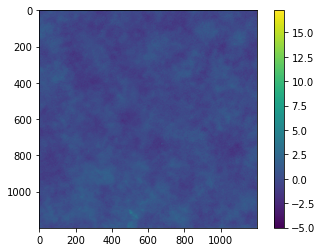

In [14]:
plt.imshow(jpg[...,2])
plt.colorbar()

In [15]:
np.amax(jpg[...,2])

17.249704360961914

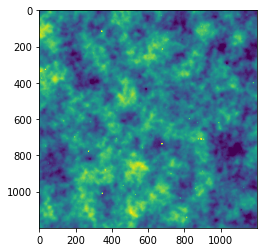

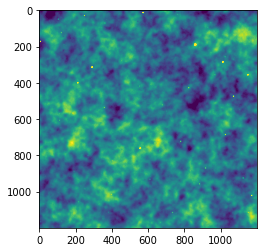

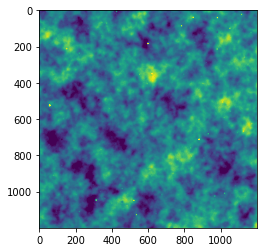

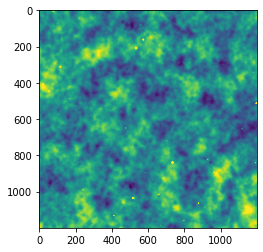

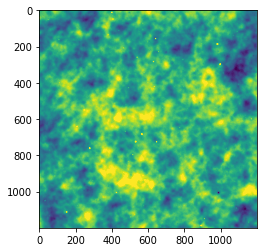

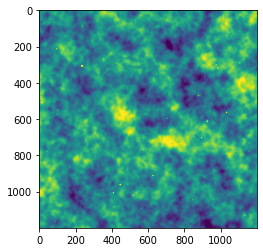

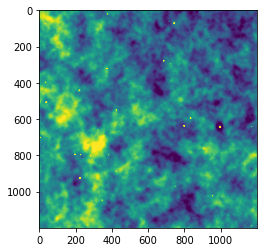

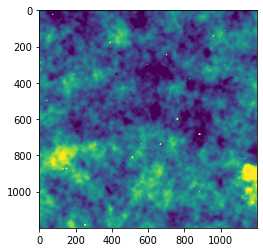

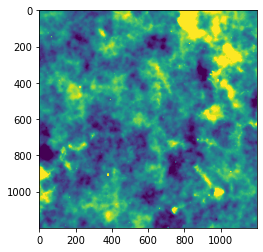

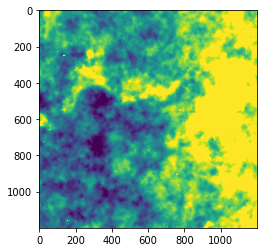

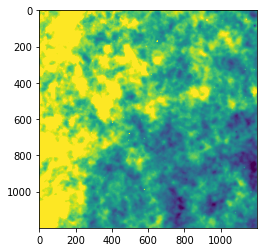

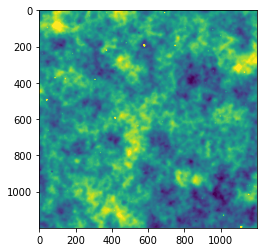

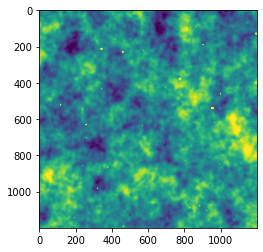

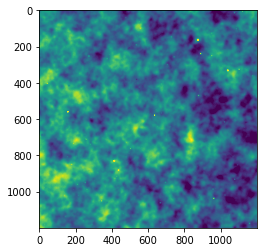

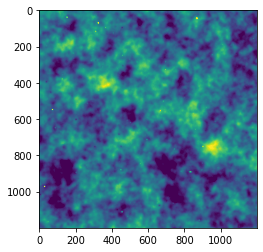

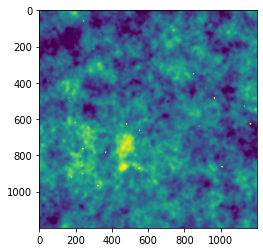

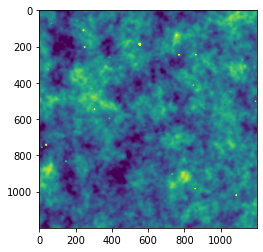

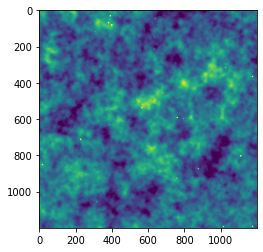

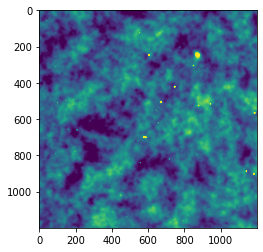

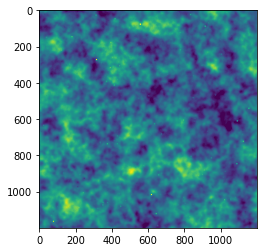

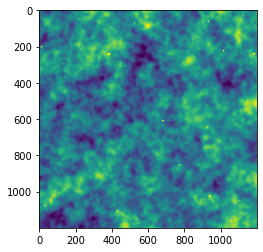

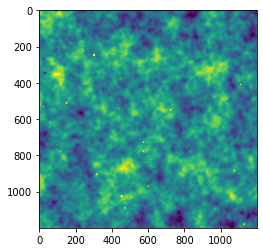

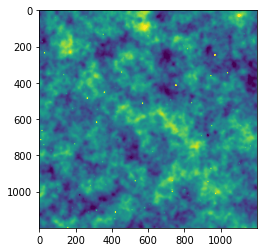

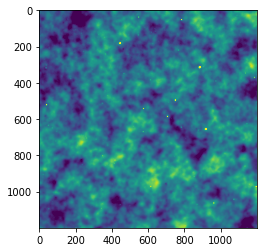

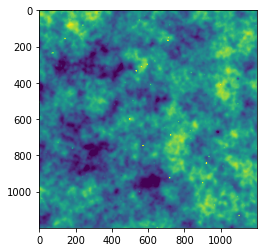

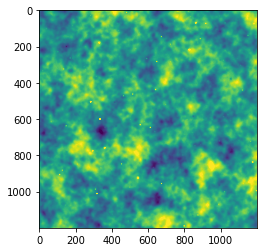

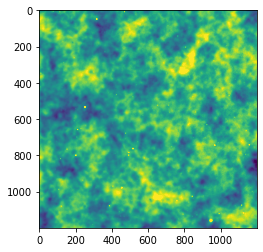

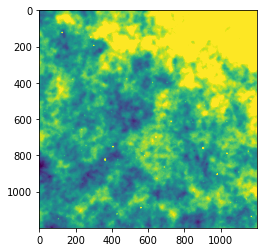

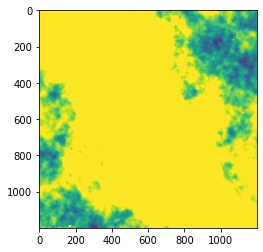

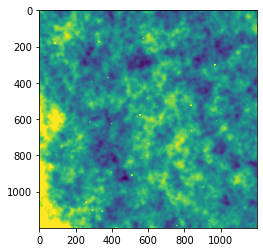

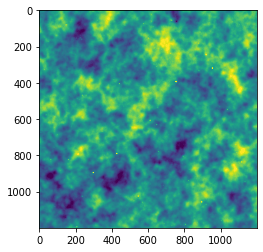

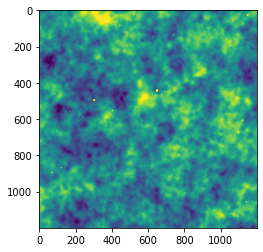

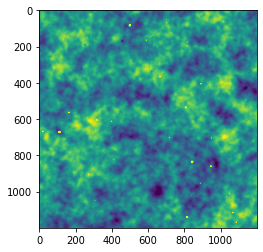

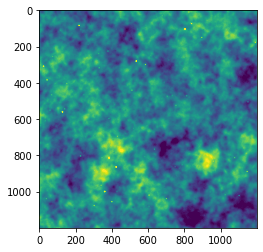

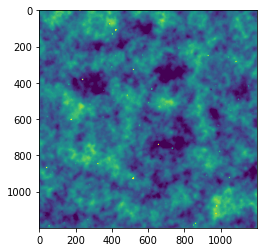

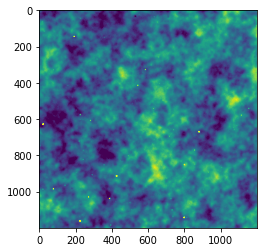

In [11]:
for i in range(0, 360, 10):
    ra_min = i; ra_max = i+10
    dec_min = 0; dec_max = 10
    #TODO: Galaxy masking
    box = np.array([[dec_min,ra_min],[dec_max,ra_max]]) * utils.degree
    cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]), box=box)
    plt.imshow(cur_map[0], vmin=-300, vmax = 300)
    plt.show()
    plt.close()

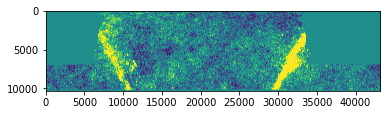

In [6]:
plt.imshow(cur_map[0], vmin=-300, vmax = 300)

In [12]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

actRa = act_catalog[1].data['RADeg']
actNames = act_catalog[1].data['name']
actDec = act_catalog[1].data['decDeg']
actRa, actDec = np.array(actRa), np.array(actDec)
actSnr = act_catalog[1].data['fixed_SNR']
actz = act_catalog[1].data['redshift']

In [13]:
#path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'

#tileName = tileFinder(actRa[0], actDec[0], s18d)
#tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
ra, dec = actRa[0]*u.deg, actDec[0]*u.deg
stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=5*utils.arcmin,
                            apod = 2*utils.arcmin)#5.*np.pi/(60*180))
#plot = enplot.plot(stamp)
#enplot.show(plot)

(3, 41, 41)


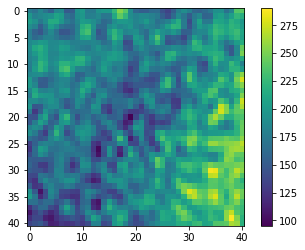

In [17]:
plt.imshow(stamp[0])
print(stamp.shape)
plt.colorbar()

In [31]:
print(min(np.abs(stamp.wcs.wcs.cdelt))*utils.degree/2)
print(min(np.abs(stamp.wcs.wcs.cdelt))*utils.degree/2*(3600 * 180)/np.pi)
print(0.004167*(60 * 180)/np.pi)

3.6361026083215055e-05
7.49999999999997
14.325090793860841


In [32]:
print(10/41*60)

14.634146341463413


In [33]:
print(cur_map.wcs.wcs.cdelt)
print(stamp.wcs.wcs.cdelt)

[-0.00833333  0.00833333]
[-0.00416667  0.00416667]


In [34]:
ra, dec = actRa[0], actDec[0]
stamp1 = freq_cutout(ra, dec, cur_map, scale = 399, width = 5*utils.arcmin)
plt.imshow(stamp1)
print(stamp.shape)

MemoryError: Unable to allocate 1.17 TiB for an array with shape (1197, 16359, 16359) and data type float32

In [ ]:
stamp2 = freq_cutout(ra, dec, cur_map, scale = 399, width = 5*utils.arcmin)
plt.imshow(stamp2)
print(stamp.shape)

In [ ]:
plt.imshow((stamp1-stamp2)/stamp1)
plt.colorbar()



In [ ]:
stamp = 0
for i in range(len(actRa)):
    ra, dec = actRa[i]*u.deg, actDec[i]*u.deg
    full_box  = reproject.thumbnails(cur_map, (dec.to(u.radian).value, ra.to(u.radian).value), r=20.*np.pi/(60*180))
    stamp+=full_box

In [ ]:
plt.imshow(stamp)

In [ ]:
path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'

freq_map_090 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f090_night_map.fits')
freq_map_150 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f150_night_map.fits')
freq_map_220 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f220_night_map.fits')

temp = cutout(actRa[:2], actDec[:2], freq_map_090, freq_map_150, freq_map_220, scale = 10)

In [ ]:
for i in range(8):
    plt.imshow(temp[1][...,i])
    plt.show()
    plt.close()

In [ ]:
temp[0][7]-temp[1][7]

In [ ]:
temp[1][6]